In [68]:
import pandas as np
df = np.read_csv('mbti_1.csv')

# populating types array
labels = []
for _type in df['type']:
     labels.append(_type)

In [69]:
import pickle

posts = []
with open ('processed_posts.pkl', 'rb') as fp:
    posts = pickle.load(fp)

In [70]:
posts[0]

['what has been the most life chang experi in your life',
 'may the perc experi immers you',
 'hello sorri to hear of your distress it onli natur for relationship to not be perfect all the time in everi moment of exist tri to figur the hard time as time of growth as',
 'welcom and stuff',
 'prozac wellbrutin at least thirti minut of move your leg and don mean move them while sit in your same desk chair weed in moder mayb tri edibl as healthier altern',
 'basic come up with three item you ve determin that each type or whichev type you want to do would more than like use given each type cognit function and whatnot when left by',
 'all thing in moder sim is inde video game and good one at that note good one at that is somewhat subject in that am not complet promot the death of ani given sim',
 'dear what were your favorit video game grow up and what are your now current favorit video game cool',
 'it appear to be too late sad',
 'there someon out there for everyon',
 'wait thought confid 

In [47]:
tokenized_posts = []

for post in posts:
    user = []
    for sentence in post:
        user += sentence.split(" ")
        
    tokenized_posts.append(user)

In [48]:
all_words_list = []

for user in tokenized_posts:
    for word in user:
        all_words_list.append(word)

In [49]:
from collections import Counter

In [50]:
freq_list = Counter(all_words_list)
dictionary = freq_list.most_common(10000)

In [51]:
dictionary = list(zip(*dictionary))[0]

In [52]:
nums = range(0, 10000)
word_int = dict(zip(dictionary, nums))

In [53]:
x_vals = []
for user in tokenized_posts:
    x_vals.append([word_int[x] for x in user if x in word_int.keys()])

In [54]:
type_dictionary = {
    '0000':'INTJ',
    '0001':'INTP',
    '0010':'INFJ',
    '0011':'INFP',
    '0100':'ISTJ',
    '0101':'ISTP',
    '0110':'ISFJ',
    '0111':'ISFP',
    '1000':'ENTJ',
    '1001':'ENTP',
    '1010':'ENFJ',
    '1011':'ENFP',
    '1100':'ESTJ',
    '1101':'ESTP',
    '1110':'ESFJ',
    '1111':'ESFP',
}

type_labels=['INTJ','INTP','INFJ','INFP','ISTJ','ISTP','ISFJ','ISFP', \
        'ENTJ','ENTP','ENFJ','ENFP','ESTJ','ESTP','ESFJ','ESFP',]

def to_one_hot(arr):
    one_hot_types = []

    for label in arr:
        bin_type = []

        if (label[0] == 'I'):
            bin_type.append(0)
        else:
            bin_type.append(1)

        if (label[1] == 'N'):
            bin_type.append(0)
        else:
            bin_type.append(1)

        if (label[2] == 'T'):
            bin_type.append(0)
        else:
            bin_type.append(1)

        if (label[3] == 'J'):
            bin_type.append(0)
        else:
            bin_type.append(1)

        one_hot_types.append(bin_type)
        
    return one_hot_types
    

In [55]:
import numpy as np
from keras.utils.np_utils import to_categorical

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x = vectorize_sequences(x_vals)
y = np.asarray(to_one_hot(labels)).astype('float32')



In [56]:
indices = np.arange(x.shape[0])
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

In [57]:
x_test = x[:1000]
y_test = y[:1000]

x_train = x[1000:]
y_train = y[1000:]

x_val = x_train[:500]
y_val = y_train[:500]

partial_x_train = x_train[500:]
partial_y_train = y_train[500:]

In [58]:
class_weights = [{0:1, 1:8}, {0:1, 1:6.24}, {0:1, 1:1.18}, {0:1, 1:0.65}]

In [59]:
# FEED FORWARD MODEL
from keras import models
from keras import layers
from keras.regularizers import l2
import tensorflow as tf
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape = (10000,)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(4, activation='sigmoid'))
    model.compile(optimizer = 'rmsprop',
                  loss = 'binary_crossentropy',
                  metrics = ['acc'])
    return model

In [63]:
from keras.callbacks import Callback

class True_eval(Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data
        self.total_accuracy = []
        self.i_accuracy = []
        self.e_accuracy = []
        self.n_accuracy = []
        self.s_accuracy = []
        self.t_accuracy = []
        self.f_accuracy = []
        self.j_accuracy = []
        self.p_accuracy = []
    
    def total_real_acc(self, prediction):
        y_true = self.validation_data[1]
        y_pred = prediction
        acc = 0
        for i in range(0, len(y_pred)):
            if (y_pred[i].round().tolist() == y_true[i].tolist()):
                acc +=1
        return acc/len(y_pred)
    
    def ie_real_acc(self, prediction):
        y_true = self.validation_data[1][:,0]
        y_pred = prediction[:,0]
        i_acc = 0
        i_total = 0
        e_acc = 0
        e_total = 0
        for i in range(0, len(y_pred)):
            if (y_true[i] == 0):
                if (y_pred[i].round() == y_true[i]):
                    i_acc += 1
                i_total += 1
            else:
                if (y_pred[i].round() == y_true[i]):
                    e_acc += 1
                e_total += 1
        return (i_acc/i_total), (e_acc/e_total)
    
    def ns_real_acc(self, prediction):
        y_true = self.validation_data[1][:,1]
        y_pred = prediction[:,1]
        n_acc = 0
        n_total = 0
        s_acc = 0
        s_total = 0
        for i in range(0, len(y_pred)):
            if (y_true[i] == 0):
                if (y_pred[i].round() == y_true[i]):
                    n_acc += 1
                n_total += 1
            else:
                if (y_pred[i].round() == y_true[i]):
                    s_acc += 1
                s_total += 1
        return (n_acc/n_total), (s_acc/s_total)
    
    def tf_real_acc(self, prediction):
        y_true = self.validation_data[1][:,2]
        y_pred = prediction[:,2]
        t_acc = 0
        t_total = 0
        f_acc = 0
        f_total = 0
        for i in range(0, len(y_pred)):
            if (y_true[i] == 0):
                if (y_pred[i].round() == y_true[i]):
                    t_acc += 1
                t_total += 1
            else:
                if (y_pred[i].round() == y_true[i]):
                    f_acc += 1
                f_total += 1
        return (t_acc/t_total), (f_acc/f_total)
    
    def jp_real_acc(self, prediction):
        y_true = self.validation_data[1][:,3]
        y_pred = prediction[:,3]
        j_acc = 0
        j_total = 0
        p_acc = 0
        p_total = 0
        for i in range(0, len(y_pred)):
            if (y_true[i] == 0):
                if (y_pred[i].round() == y_true[i]):
                    j_acc += 1
                j_total += 1
            else:
                if (y_pred[i].round() == y_true[i]):
                    p_acc += 1
                p_total += 1
        return (j_acc/j_total), (p_acc/p_total)
        
    
    def on_epoch_end(self, epoch, logs={}):
        x_val = self.validation_data[0]
        prediction = self.model.predict(x_val)
        total_real_acc = self.total_real_acc(prediction)
        i_real_acc, e_real_acc = self.ie_real_acc(prediction)
        n_real_acc, s_real_acc = self.ns_real_acc(prediction)
        t_real_acc, f_real_acc = self.tf_real_acc(prediction)
        j_real_acc, p_real_acc = self.jp_real_acc(prediction)
        print ("Real Accuracy: %f" % total_real_acc)
        self.total_accuracy.append(total_real_acc)
        self.i_accuracy.append(i_real_acc)
        self.e_accuracy.append(e_real_acc)
        self.n_accuracy.append(n_real_acc)
        self.s_accuracy.append(s_real_acc)
        self.t_accuracy.append(t_real_acc)
        self.f_accuracy.append(f_real_acc)
        self.j_accuracy.append(j_real_acc)
        self.p_accuracy.append(p_real_acc)

In [64]:
model = build_model()
with tf.device('/gpu:0'):
    true_metrics = True_eval((x_val, y_val))
    history = model.fit(partial_x_train, partial_y_train, validation_data= (x_val, y_val), epochs = 100, batch_size = 512, class_weight=class_weights, callbacks=[true_metrics])

Train on 7175 samples, validate on 500 samples
Epoch 1/100
7175/7175 [==============================] - 1s 123us/step - loss: 0.6946 - acc: 0.6046 - val_loss: 0.6861 - val_acc: 0.7045
Real Accuracy: 0.214000
Epoch 2/100
7175/7175 [==============================] - 1s 90us/step - loss: 0.6845 - acc: 0.6880 - val_loss: 0.6811 - val_acc: 0.7080
Real Accuracy: 0.218000
Epoch 3/100
7175/7175 [==============================] - 1s 82us/step - loss: 0.6796 - acc: 0.6873 - val_loss: 0.6759 - val_acc: 0.7025
Real Accuracy: 0.208000
Epoch 4/100
7175/7175 [==============================] - 1s 86us/step - loss: 0.6743 - acc: 0.6599 - val_loss: 0.6720 - val_acc: 0.5355
Real Accuracy: 0.028000
Epoch 5/100
7175/7175 [==============================] - 1s 88us/step - loss: 0.6627 - acc: 0.6402 - val_loss: 0.6600 - val_acc: 0.7065
Real Accuracy: 0.216000
Epoch 6/100
7175/7175 [==============================] - 1s 87us/step - loss: 0.6493 - acc: 0.6830 - val_loss: 0.6502 - val_acc: 0.7045
Real Accuracy: 0

Real Accuracy: 0.342000
Epoch 52/100
7175/7175 [==============================] - 1s 79us/step - loss: 0.0982 - acc: 0.9802 - val_loss: 0.6416 - val_acc: 0.7560
Real Accuracy: 0.330000
Epoch 53/100
7175/7175 [==============================] - 1s 78us/step - loss: 0.1007 - acc: 0.9760 - val_loss: 0.6619 - val_acc: 0.7670
Real Accuracy: 0.348000
Epoch 54/100
7175/7175 [==============================] - 1s 78us/step - loss: 0.0845 - acc: 0.9856 - val_loss: 0.6620 - val_acc: 0.7475
Real Accuracy: 0.314000
Epoch 55/100
7175/7175 [==============================] - 1s 79us/step - loss: 0.0821 - acc: 0.9862 - val_loss: 0.6769 - val_acc: 0.7495
Real Accuracy: 0.322000
Epoch 56/100
7175/7175 [==============================] - 1s 79us/step - loss: 0.0757 - acc: 0.9875 - val_loss: 0.6878 - val_acc: 0.7655
Real Accuracy: 0.360000
Epoch 57/100
7175/7175 [==============================] - 1s 79us/step - loss: 0.0757 - acc: 0.9860 - val_loss: 0.7780 - val_acc: 0.7420
Real Accuracy: 0.328000
Epoch 58/1

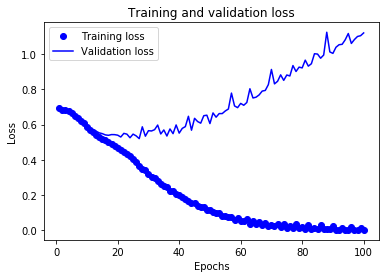

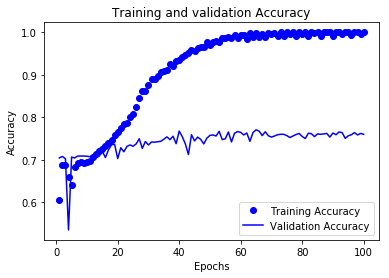

<Figure size 432x288 with 0 Axes>

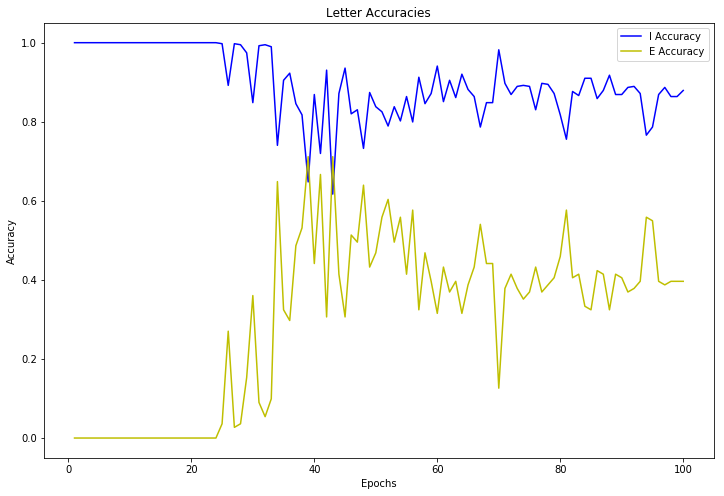

<Figure size 432x288 with 0 Axes>

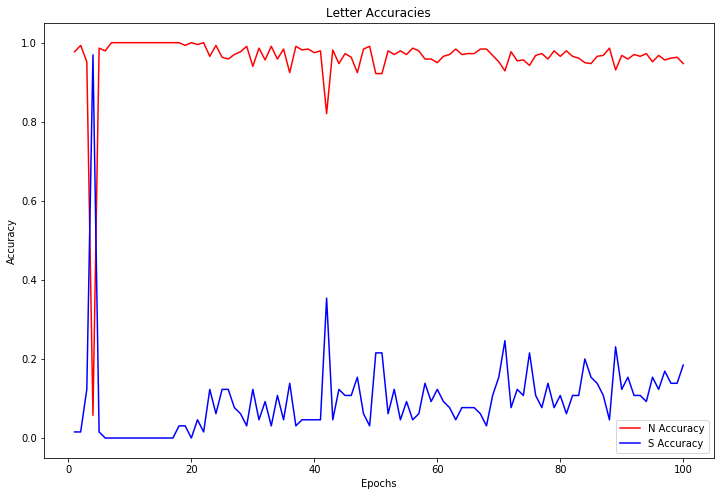

<Figure size 432x288 with 0 Axes>

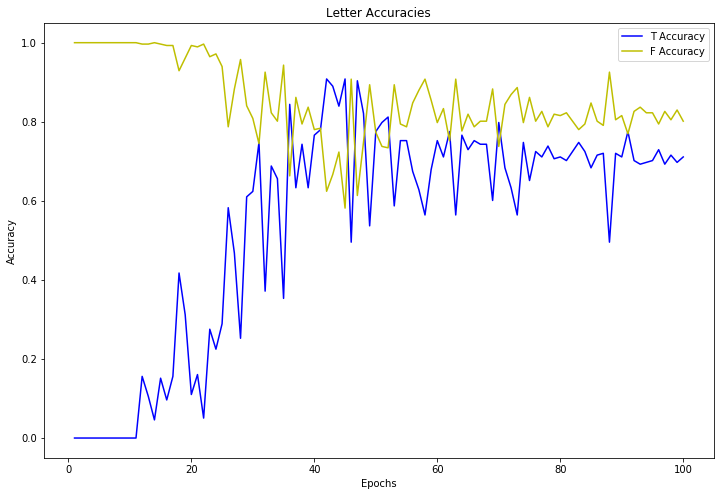

<Figure size 432x288 with 0 Axes>

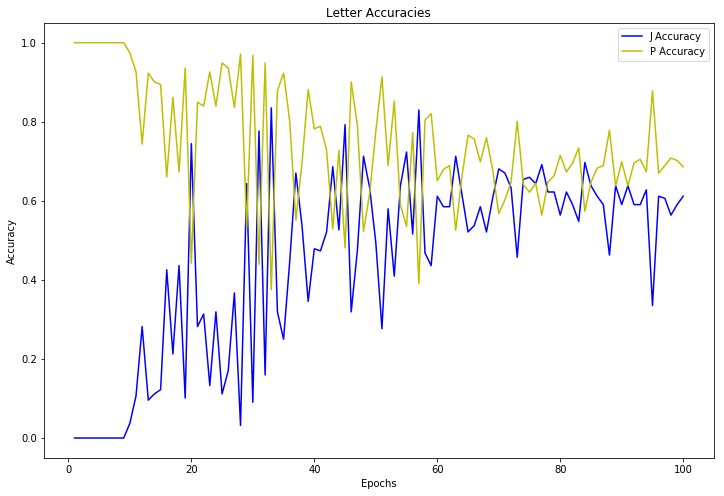

In [65]:
import matplotlib.pyplot as plt

history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

train_acc = history_dict['acc']
val_acc   = history_dict['val_acc']

epochs = range(1, len(history_dict['acc']) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, train_acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

plt.clf()

plt.figure(figsize=(12,8))
plt.plot(epochs, true_metrics.i_accuracy, 'b', label='I Accuracy')
plt.plot(epochs, true_metrics.e_accuracy, 'y', label='E Accuracy')
plt.title('Letter Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


plt.clf()

plt.figure(figsize=(12,8))
plt.plot(epochs, true_metrics.n_accuracy, 'r', label='N Accuracy')
plt.plot(epochs, true_metrics.s_accuracy, 'b', label='S Accuracy')
plt.title('Letter Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

plt.clf()

plt.figure(figsize=(12,8))
plt.plot(epochs, true_metrics.t_accuracy, 'b', label='T Accuracy')
plt.plot(epochs, true_metrics.f_accuracy, 'y', label='F Accuracy')
plt.title('Letter Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

plt.clf()

plt.figure(figsize=(12,8))
plt.plot(epochs, true_metrics.j_accuracy, 'b', label='J Accuracy')
plt.plot(epochs, true_metrics.p_accuracy, 'y', label='P Accuracy')
plt.title('Letter Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [66]:
model = build_model()
with tf.device('/gpu:0'):
    model.fit(x_train, y_train, epochs = 50, batch_size = 512, class_weight=class_weights)
    y_pred = model.predict(x_test)
    results = model.evaluate(x_test, y_test)
results

Epoch 1/50
7675/7675 [==============================] - 1s 109us/step - loss: 0.6037 - acc: 0.6788
Epoch 2/50
7675/7675 [==============================] - 1s 89us/step - loss: 0.5468 - acc: 0.7339
Epoch 3/50
7675/7675 [==============================] - 1s 86us/step - loss: 0.5249 - acc: 0.7533
Epoch 4/50
7675/7675 [==============================] - 1s 81us/step - loss: 0.5039 - acc: 0.7714
Epoch 5/50
7675/7675 [==============================] - 1s 79us/step - loss: 0.4808 - acc: 0.7911
Epoch 6/50
7675/7675 [==============================] - 1s 84us/step - loss: 0.4597 - acc: 0.8011
Epoch 7/50
7675/7675 [==============================] - 1s 78us/step - loss: 0.4348 - acc: 0.8192
Epoch 8/50
7675/7675 [==============================] - 1s 74us/step - loss: 0.4132 - acc: 0.8297
Epoch 9/50
7675/7675 [==============================] - 1s 92us/step - loss: 0.3952 - acc: 0.8433
Epoch 10/50
7675/7675 [==============================] - 1s 76us/step - loss: 0.3757 - acc: 0.8476
Epoch 11/50
7675/7

[0.7437260332107544, 0.75775]

Normalized confusion matrix


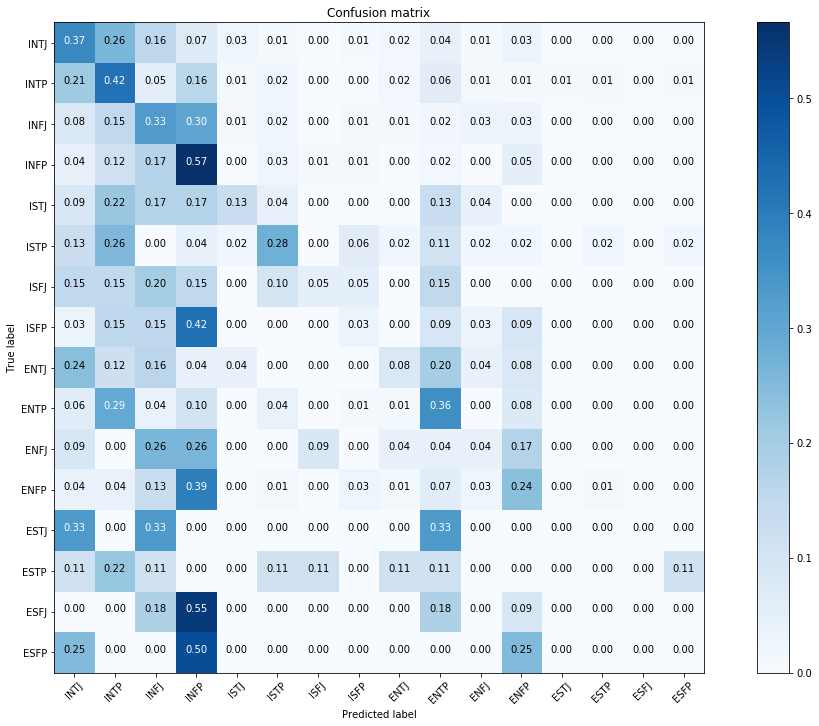

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

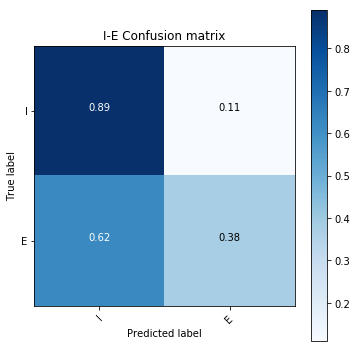

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

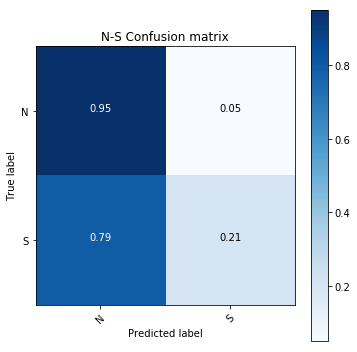

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

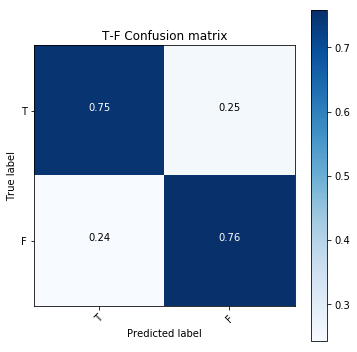

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

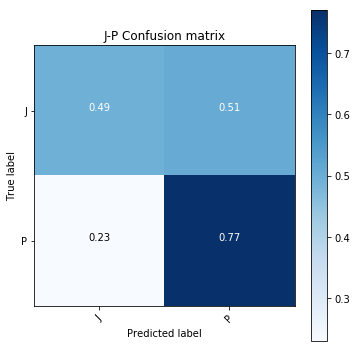

In [67]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import datetime

now = datetime.datetime.now()
pictures = []
folder = "FF"

def byte_to_mbti(byte):
    binary = ''
    for letter in byte:
         binary +=(str(int(letter)))        
    return type_dictionary[binary]

decoded_y_true = [byte_to_mbti(label) for label in y_test.round()]
decoded_y_pred = [byte_to_mbti(label) for label in y_pred.round()]

matrix = confusion_matrix(decoded_y_true, decoded_y_pred, labels=type_labels)
matrix_I_E = confusion_matrix(y_test[:,0], y_pred[:,0].round(), labels=[0, 1])
matrix_N_S = confusion_matrix(y_test[:,1], y_pred[:,1].round(), labels=[0, 1])
matrix_T_F = confusion_matrix(y_test[:,2], y_pred[:,2].round(), labels=[0, 1])
matrix_J_P = confusion_matrix(y_test[:,3], y_pred[:,3].round(), labels=[0, 1])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plt.figure(figsize=(15,10))
plot_confusion_matrix(matrix, classes=type_labels, normalize=True,
                      title='Confusion matrix')
name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
str(now.hour) + "-" + str(now.minute) + "_" + "CM0.png"
plt.savefig(name)
plt.show()
pictures.append(name)

plt.clf()
plt.figure(figsize=(5,5))
plot_confusion_matrix(matrix_I_E, classes=["I", "E"], normalize=True,
                      title='I-E Confusion matrix')
name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
str(now.hour) + "-" + str(now.minute) + "_" + "CM1.png"
plt.savefig(name)
plt.show()
pictures.append(name)

plt.clf()
plt.figure(figsize=(5,5))
plot_confusion_matrix(matrix_N_S, classes=["N", "S"], normalize=True,
                      title='N-S Confusion matrix')
name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
str(now.hour) + "-" + str(now.minute) + "_" + "CM2.png"
plt.savefig(name)
plt.show()
pictures.append(name)

plt.clf()
plt.figure(figsize=(5,5))
plot_confusion_matrix(matrix_T_F, classes=["T", "F"], normalize=True,
                      title='T-F Confusion matrix')
name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
str(now.hour) + "-" + str(now.minute) + "_" + "CM3.png"
plt.savefig(name)
plt.show()
pictures.append(name)

plt.clf()
plt.figure(figsize=(5,5))
plot_confusion_matrix(matrix_J_P, classes=["J", "P"], normalize=True,
                      title='J-P Confusion matrix')
name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
str(now.hour) + "-" + str(now.minute) + "_" + "CM4.png"
plt.savefig(name)
plt.show()
pictures.append(name)

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

train_acc = history_dict['acc']
val_acc   = history_dict['val_acc']

epochs = range(1, len(history_dict['acc']) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, train_acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()